# ISIDORA

When a man rides a long time through wild regions he feels the desire for a city. Finally he comes to Isidora, a city where the buildings have spiral staircases encrusted with spiral seashells, where perfect telescopes and violins are made, where the foreigner hesitating between two women always encounters a third, where cockfights degenerate into bloody brawls among the bettors. He was thinking of all these things when he desired a city. Isidora, therefore, is the city of his dreams: with one difference. The dreamed-of city contained him as a young man; he arrives at Isidora in his old age. In the square there is the wall where the old men sit and watch the young go by; he is seated in a row with them. Desires are already memories.

In [2]:
from __future__ import print_function
from IPython.display import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


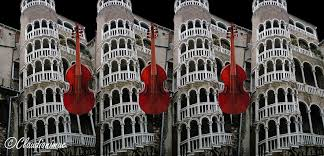

In [3]:
Image(filename='../Images/Isidora.jpg') 

1. reads a file containing MCRDST data
2. Creates Panda DF to describe the PMT and SiPM metadata
3. Creates a Panda DF to store the energy (in PES) of each PMT for each event
4. Simulates response of the EP FEE and decimates waveforms according to DAQ
5. Writes a new Nh5 DST

In [5]:
import pandas as pd
import tables as tb
import numpy as np

In [210]:
from system_of_units import *

In [218]:
from PlotUtil import *

### DBLR

#### Reaout RWF DST

In [285]:
h5f = tb.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_0_RWF.h5', "a") 

In [288]:
pmtrd_ = h5f.root.RD.pmtrd

In [289]:
pmtrd_.shape

(99, 12, 24000)

In [291]:
signal_t = np.arange(0.0, pmtrd_.shape[2]*1., 1., dtype=np.double)

In [296]:
import FEParam as FP

In [321]:
from scipy import signal as SGN

### Deconvolution function

In [326]:

def BLR(signal_daq, coef, n_sigma = 3, NOISE_ADC=0.7, 
        thr1 = 0, thr2 = 0, thr3 = 0, plot = False, log='DEBUG'):
    """
    Deconvolution offline of the DAQ signal using a MAU
    moving window-average filter of a vector data
    y(n) = (1/WindowSize)(x(n) + x(n-1) + ... + x(n-windowSize))
    in a filter operation filter(b,a,x):
    b = (1/WindowSize)*ones(WindowSize) = (1/WS)*[1,1,1,...]: numerator
    a = 1 : denominator
    y = filter(b,a,x)
    y[0] = b[0]*x[0] = (1/WS) * x[0]
    y[1] = (1/WS) * (x[0] + x[1])
    y[WS-1] = mean(x[0:WS])
    y[WS] = mean(x[1:WS+1])
    and so on
    """
    import logging
    logl ='logging.'+log
    logging.basicConfig(level=eval(logl))
    
    MAU_WindowSize = FP.MAU_WindowSize
    time_DAQ = FP.time_bin

    len_signal_daq = len(signal_daq)
    MAU = np.zeros(len_signal_daq, dtype=np.double)
    acum = np.zeros(len_signal_daq, dtype=np.double)
    signal_r = np.zeros(len_signal_daq, dtype=np.double)
    pulse_f = np.zeros(len(signal_daq), dtype=np.double)
    pulse_ff = np.zeros(len(signal_daq), dtype=np.double)
    pulse_t = np.zeros(len(signal_daq), dtype=np.double)
    pulse_w = np.zeros(len(signal_daq), dtype=np.double)
    
    signal_i = np.copy(signal_daq) #uses to update MAU while procesing signal


    thr = n_sigma*NOISE_ADC
    if thr1 != 0:
        thr = thr1

    thr_tr = thr/5. # to conclude BLR when signal_deconv = signal_raw

    if thr3 != 0:
        thr_tr = thr3
    
    nm = MAU_WindowSize
    B_MAU       =   (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch 
#    allows to compute the baseline of the signal  
    
    MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
    acum[nm] =  MAU[nm]
    BASELINE = MAU[nm-1]

    logging.debug("""-->BLR:: n_sigma = {}, NOISE_ADC= {}, 
        thr1 = {}, thr2 = {}, thr3 = {} =""".format(
            n_sigma, NOISE_ADC, thr1, thr2, thr3))

    if plot:
        logging.debug("n = {}, acum[n] = {} BASELINE ={}".format(nm, acum[nm],BASELINE))

        ax1 = plt.subplot(3,1,1)
        ax1.set_xlim([0, nm])
        plt.plot(MAU)
        plt.show()

#----------

# While MAU inits BLR is switched off, thus signal_r = signal_daq 

    signal_r[0:nm] = signal_daq[0:nm] 
    pulse_on=0
    wait_over=0
    offset = 0

    # MAU has computed the offset using nm samples
    # now loop until the end of DAQ window

    for k in range(nm,len_signal_daq): 

        trigger_line = MAU[k-1] + thr
        pulse_t[k] = trigger_line
        pulse_f[k] = pulse_on
        pulse_w[k] = wait_over 
        pulse_ff[k] = signal_daq[k] - signal_r[k]

        # condition: raw signal raises above trigger line and 
        # we are not in the tail
        # (wait_over == 0)
        if signal_daq[k] > trigger_line and wait_over == 0:

            # if the pulse just started pulse_on = 0.
            # In this case compute the offset as value 
            #of the MAU before pulse starts (at k-1)

            if pulse_on == 0: # pulse just started
                #offset computed as the value of MAU before pulse starts
                offset = MAU[k-1]  
                pulse_on = 1 

            #Freeze the MAU
            MAU[k] = MAU[k-1]  
            signal_i[k] =MAU[k-1]  #signal_i follows the MAU
            
            #update recovered signal, correcting by offset
            acum[k] = acum[k-1] + signal_daq[k] - offset;
            signal_r[k] = signal_daq[k] + coef*acum[k] 
            
        else:  #raw signal just dropped below threshold
        # but raw signal can be negative for a while and still contribute to the
        # reconstructed signal.

            if pulse_on == 1: #reconstructed signal still on
            # switch the pulse off only when recovered signal 
            #drops below threshold
                
                #slide the MAU, still frozen. 
                # keep recovering signal
                MAU[k] = MAU[k-1]  
                signal_i[k] =MAU[k-1]
                acum[k] = acum[k-1] + signal_daq[k] - offset;
                signal_r[k] = signal_daq[k] + coef*acum[k] 
            
                #if the recovered signal drops before trigger line 
                #rec pulse is over!
                if signal_r[k] < trigger_line + thr2:
                    wait_over = 1  #start tail compensation
                    pulse_on = 0   #recovered pulse is over

            else:  #recovered signal has droped below trigger line
            #need to compensate the tail to avoid drifting due to erros in 
            #baseline calculatoin

                if wait_over == 1: #compensating pulse
                    # recovered signal and raw signal 
                    #must be equal within a threshold
                    # otherwise keep compensating pluse


                    if signal_daq[k-1] < signal_r[k-1] - thr_tr:
                        # raw signal still below recovered signal 

                        # is the recovered signal near offset?
                        upper = offset + (thr_tr + thr2)
                        lower = offset - (thr_tr + thr2)

                        if signal_r[k-1] > lower and signal_r[k-1] < upper:
                            # we are near offset, activate MAU. 
                            #signal_i follows rec signal
                            
                            signal_i[k] = signal_r[k-1]
                            MAU[k] = np.sum(signal_i[k-nm:k])/nm

                        else: 
                            # rec signal not near offset MAU frozen 
                                
                            MAU[k] = MAU[k-1]
                            signal_i[k] = MAU[k-1]

                        # keep adding recovered signal until 
                        # it raises above the raw signal 

                        acum[k] = acum[k-1] + signal_daq[k] - MAU[k]
                        signal_r[k] = signal_daq[k] + coef*acum[k]

                    else:  # input signal above recovered signal: we are done
                        wait_over = 0
                        acum[k] = MAU[k-1]
                        signal_r[k] = signal_daq[k]
                        signal_i[k] = signal_r[k]
                        MAU[k] = np.sum(signal_i[k-nm:k])/nm
                else:
                    wait_over = 0
                    acum[k] = MAU[k-1]
                    signal_r[k] = signal_daq[k]
                    signal_i[k] = signal_r[k]
                    MAU[k] = np.sum(signal_i[k-nm:k])/nm

    #energy = np.dot(pulse_f,(signal_r-BASELINE))*FP.time_DAQ
    energy = np.dot(pulse_f,(signal_r-BASELINE)) #already scaled in FEE2

    if plot:
        logging.debug("Baseline = {}, energy = {} ".format(BASELINE, energy))

        ax1 = plt.subplot(3,2,1)
        ax1.set_xlim([7000, 10000])
        plt.plot(pulse_f, color='red')

        ax2 = plt.subplot(3,2,2)
        ax2.set_xlim([7000, 10000])
        plt.plot(pulse_w, color='green')

        ax3 = plt.subplot(3,2,3)
        ax3.set_xlim([7000, 10000])
        plt.plot(pulse_ff, color='black')

        ax4 = plt.subplot(3,2,4)
        ax4.set_xlim([7000, 10000])
        plt.plot(signal_daq, color='yellow')

        ax5 = plt.subplot(3,2,5)
        plt.plot(signal_r-BASELINE)
        ax5.set_xlim([7000, 20000])

        ax5 = plt.subplot(3,2,6)
        plt.plot(pulse_t, color='orange')
        ax5.set_xlim([7000, 10000])

        plt.show()
                       
    return  signal_r-BASELINE, energy

In [300]:
def inverse_signal(pmtrd_,signal_t, event_number,CA):
    """
    Peform Base line Restoration
    CA is an array with the values of the capacitances for the PMTs
    """
    import FEParam as FP
    import FEE2 as FE
    
    len_WF = pmtrd_.shape[2]
    NPMT = pmtrd_.shape[1]
    ene_pmt =np.zeros(len_WF, dtype=np.int32)
    
    inv = []
    for j in range(NPMT):
        pmtrd = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        
        #Deconvolution
        fee = FE.FEE(C=CA[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(signal_t)  #inverse function
        inv.append( signal_inv_daq)
    return pd.Series(inv)

In [301]:
idf = inverse_signal(pmtrd_,signal_t,event_number = 0, CA=FP.C12)

In [309]:
idf

0     [1.0008821504, 0.00176430079652, 0.00176430079...
1     [1.00085441719, 0.00170883437651, 0.0017088343...
2     [1.00087671552, 0.00175343104735, 0.0017534310...
3     [1.00085494967, 0.00170989934246, 0.0017098993...
4     [1.00084430984, 0.00168861968206, 0.0016886196...
5     [1.00087214571, 0.00174429142726, 0.0017442914...
6     [1.00086030101, 0.00172060201819, 0.0017206020...
7     [1.00085547749, 0.00171095498465, 0.0017109549...
8     [1.00085888793, 0.0017177758591, 0.00171777585...
9     [1.00084361486, 0.00168722971163, 0.0016872297...
10    [1.00085742975, 0.00171485949265, 0.0017148594...
11    [1.00084266276, 0.00168532552339, 0.0016853255...
dtype: object

In [319]:
def plot_inverse(wfdf):
    """
    plot the inverse function
    """
    
    plt.figure(figsize=(12,12))
    
    for i in range(12):
        wf = wfdf.ix[i]
        ax1 = plt.subplot(3,4,i+1)
        ax1.set_xlim([0, len(wf)])
        SetPlotLabels(xlabel='t (ns)', ylabel='adc')
        plt.plot(wf[1:])

    plt.show()

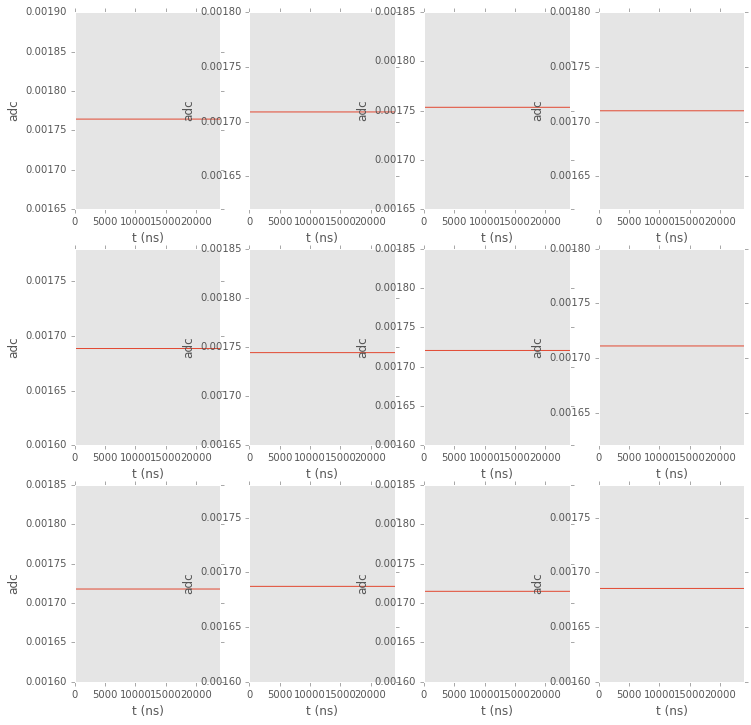

In [320]:
plot_inverse(idf)

In [327]:
def DBLR(pmtrd_,signal_t, event_number, CA, nsigma=3, plot='True' ):
    """
    Peform Base line Restoration
    CA is an array with the values of the capacitances for the PMTs
    """
    import FEParam as FP
    import FEE2 as FE
    
    len_WF = pmtrd_.shape[2]
    NPMT = pmtrd_.shape[1]
    ene_pmt =np.zeros(NPMT, dtype=np.int32)
    coef_pmt =np.zeros(NPMT, dtype=np.double)
    
    ipmt = 0
    PMTWF ={}
    
    for j in NPMT:
        logging.debug("-->PMT number ={}".format(j))

        pmtrd = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        
        #Deconvolution
        fee = FE.FEE(C=CA[ipmt],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(CP.signal_t)  #inverse function
        coef = signal_inv_daq[10]  #accumulator coefficient
        COEF.append(coef)
       
   
        signal_blr, eadc = BLR(pmtrd, coef, n_sigma = nsigma, 
                            NOISE_ADC=FP.NOISE_ADC, 
                            thr2=FP.NOISE_ADC/4., thr3 = FP.NOISE_ADC/2.,
                            plot=plot)
    
        if plot == True:
            print("DBLR signal")
            plot_signal(signal_t,signal_blr, title = 'signal BLR', 
                    signal_start=0, signal_end=len_WF, 
                    units='adc')

        ene_pmt[ipmt] = eadc
        coef_pmt[ipmt] = coef
        PMTWF[ipmt]=signal_blr
        ipmt+=1
    return pd.Series(ene_pmt), pd.Series(ene_coef), pd.DataFrame(PMTWF)

def plot_waveforms(pmtwf, indx=0):
    pmt = pmtwf[indx]
    
    plt.figure(figsize=(12,12))
    
    len_pmt = len(pmt[0])
    for i in range(12):
        ax1 = plt.subplot(3,4,i+1)
        ax1.set_xlim([0, len_pmt])
        SetPlotLabels(xlabel='t (ns)', ylabel='adc')
        plt.plot(pmt[i])

    
    plt.show()

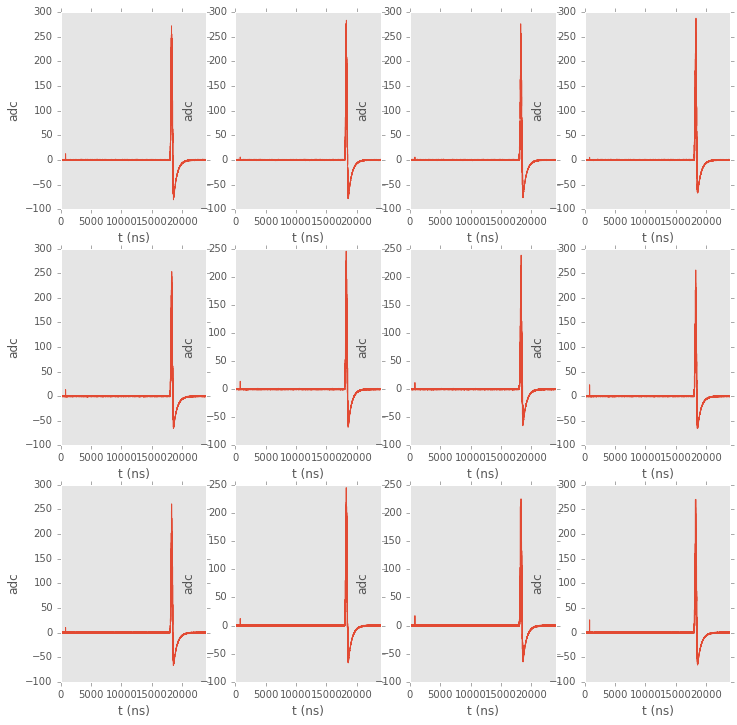

In [224]:
plot_waveforms(pmtwf, indx=0)

In [233]:
def read_Nh5Dst_PMT(pfile,nevents=1):
    """
    Read the PMTs
    """

    with tb.open_file(pfile, "r") as h5in:
        print(h5in)
        pmtrd_ = h5in.root.pmtrd
        print("pmtrd_ shape = {}".format(pmtrd_.shape))
        nev = min(nevents,pmtrd_.shape[0])
        npmt = pmtrd_.shape[1]
        
        print("number of PMTs = {}".format(npmt))
        print("running over {} events".format(nev))
        PMT={}
        for i in range(nev):
            rdata =[]
            for j in range(npmt):
                print("pmt number = {}".format(j))
                rdata.append(pmtrd_[i, j])
            PMT[i]= rdata
        return PMT
        

In [226]:
path="/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/"

In [227]:
ffile="WF_Tl_0.h5"

In [234]:
pmtwf2 = read_Nh5Dst_PMT(path+ffile,nevents=1)

/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Tl_0.h5 (File) ''
Last modif.: 'Tue Aug  9 19:37:52 2016'
Object Tree: 
/ (RootGroup) ''
/pmtrd (EArray(10, 12, 24000), shuffle, blosc(9)) ''
/sipmrd (EArray(10, 1792, 600), shuffle, blosc(9)) ''
/SimulationParameters (Group) ''
/SimulationParameters/FEE (Table(1,)) 'SimulationParameters'

pmtrd_ shape = (10, 12, 24000)
number of PMTs = 12
running over 1 events
pmt number = 0
pmt number = 1
pmt number = 2
pmt number = 3
pmt number = 4
pmt number = 5
pmt number = 6
pmt number = 7
pmt number = 8
pmt number = 9
pmt number = 10
pmt number = 11


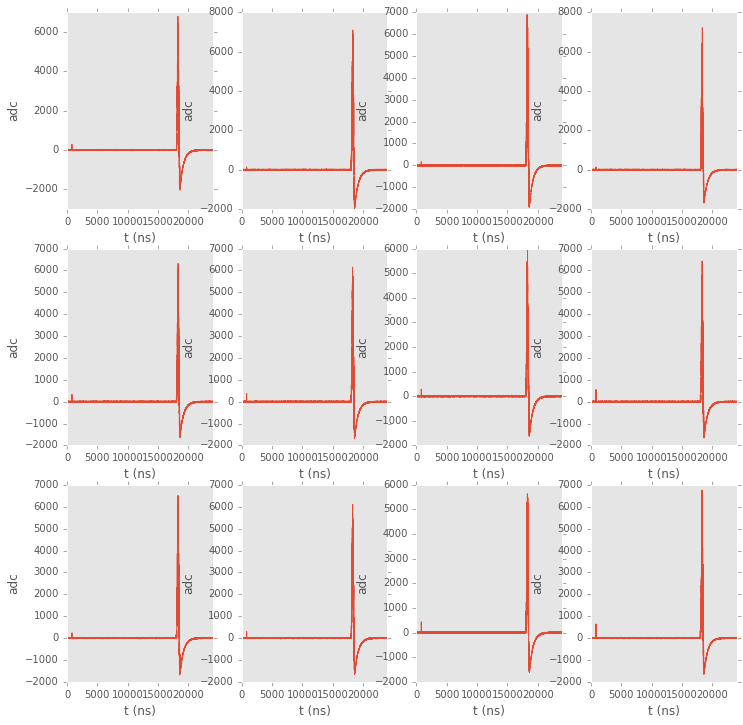

In [235]:
plot_waveforms(pmtwf2, indx=0)

In [246]:
def read_Nh5Dst_SiPM(pfile,nevents=1):
    """
    read the SiPM
    """
    
    with tb.open_file(pfile, "r") as h5in:
        print(h5in)
        pmtrd_ = h5in.root.sipmrd
        print("sipmrd_ shape = {}".format(pmtrd_.shape))
        nev = min(nevents,pmtrd_.shape[0])
        npmt = pmtrd_.shape[1]
        
        print("number of SiPMs = {}".format(npmt))
        print("running over {} events".format(nev))
        PMT={}
        for i in range(nev):
            rdata =[]
            for j in range(npmt):
                rdata.append(pmtrd_[i, j])
            PMT[i]= rdata
        return PMT

In [247]:
sipmwf2 = read_Nh5Dst_SiPM(path+ffile,nevents=1)

/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Tl_0.h5 (File) ''
Last modif.: 'Tue Aug  9 19:37:52 2016'
Object Tree: 
/ (RootGroup) ''
/pmtrd (EArray(10, 12, 24000), shuffle, blosc(9)) ''
/sipmrd (EArray(10, 1792, 600), shuffle, blosc(9)) ''
/SimulationParameters (Group) ''
/SimulationParameters/FEE (Table(1,)) 'SimulationParameters'

sipmrd_ shape = (10, 1792, 600)
number of SiPMs = 1792
running over 1 events


In [250]:
def sipm_energy(sipmwf, indx=0):
    """
    returns an array with the energy of the SiPMs
    """
    sipm_WFS = sipmwf[indx]
    
    energy=[]
    for i in range(len(sipm_WFS)):
        sipm_wf = sipm_WFS[i]
        energy.append(np.sum(sipm_wf))
    return pd.Series(energy)

In [251]:
1

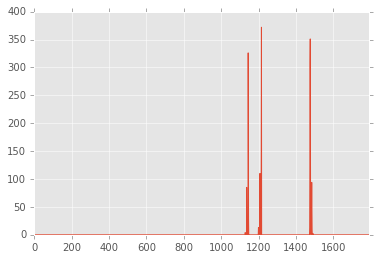

In [253]:
eneSiPM.plot()

## MC Particles

In [254]:
def read_MC(pfile,nev=1):
    """
    read the MC data
    """
    
    with tb.open_file(pfile, "r") as h5in:
        print(h5in)
        mctrk = h5in.root.MC.MCTracks
        
        return mctrk.read()

In [256]:
path='/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/'

In [257]:
mctable = read_MC(path+ffile,nev=1)

/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF_Tl_0.h5 (File) ''
Last modif.: 'Thu Aug  4 17:08:53 2016'
Object Tree: 
/ (RootGroup) ''
/pmtrd (EArray(99, 12, 599999), shuffle, blosc(9)) ''
/sipmrd (EArray(99, 1792, 600), shuffle, blosc(9)) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) 'DetectorGeometry'
/MC (Group) ''
/MC/MCTracks (Table(4311,)) 'MCTracks'
/Sensors (Group) ''
/Sensors/DataPMT (Table(12,)) 'DataPMT'
/Sensors/DataSiPM (Table(1791,)) 'DataSiPM'



In [261]:
h5in = tb.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF_Tl_0.h5','r')

In [264]:
h5out.close()

In [277]:
h5out = tb.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/test.h5','w')

In [266]:
mctrk_t = h5in.root.MC.MCTracks

In [267]:
mctrk_t

/MC/MCTracks (Table(4311,)) 'MCTracks'
  description := {
  "event_indx": Int16Col(shape=(), dflt=0, pos=0),
  "mctrk_indx": Int16Col(shape=(), dflt=0, pos=1),
  "particle_name": StringCol(itemsize=10, shape=(), dflt='', pos=2),
  "pdg_code": Int16Col(shape=(), dflt=0, pos=3),
  "initial_vertex": Float64Col(shape=(3,), dflt=0.0, pos=4),
  "final_vertex": Float64Col(shape=(3,), dflt=0.0, pos=5),
  "momentum": Float64Col(shape=(3,), dflt=0.0, pos=6),
  "energy": Float64Col(shape=(), dflt=0.0, pos=7),
  "nof_hits": Int16Col(shape=(), dflt=0, pos=8),
  "hit_indx": Int16Col(shape=(), dflt=0, pos=9),
  "hit_position": Float64Col(shape=(3,), dflt=0.0, pos=10),
  "hit_time": Float64Col(shape=(), dflt=0.0, pos=11),
  "hit_energy": Float64Col(shape=(), dflt=0.0, pos=12)}
  byteorder := 'little'
  chunkshape := (468,)

In [278]:
h5out

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/test.h5, title='', mode='w', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''

In [279]:
g = h5out.create_group('/','MC')

In [280]:
h5out

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/test.h5, title='', mode='w', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/MC (Group) ''

In [281]:
mctrk_t2 = mctrk_t.copy(newparent=g)

In [282]:
mctrk_t2

/MC/MCTracks (Table(4311,)) 'MCTracks'
  description := {
  "event_indx": Int16Col(shape=(), dflt=0, pos=0),
  "mctrk_indx": Int16Col(shape=(), dflt=0, pos=1),
  "particle_name": StringCol(itemsize=10, shape=(), dflt='', pos=2),
  "pdg_code": Int16Col(shape=(), dflt=0, pos=3),
  "initial_vertex": Float64Col(shape=(3,), dflt=0.0, pos=4),
  "final_vertex": Float64Col(shape=(3,), dflt=0.0, pos=5),
  "momentum": Float64Col(shape=(3,), dflt=0.0, pos=6),
  "energy": Float64Col(shape=(), dflt=0.0, pos=7),
  "nof_hits": Int16Col(shape=(), dflt=0, pos=8),
  "hit_indx": Int16Col(shape=(), dflt=0, pos=9),
  "hit_position": Float64Col(shape=(3,), dflt=0.0, pos=10),
  "hit_time": Float64Col(shape=(), dflt=0.0, pos=11),
  "hit_energy": Float64Col(shape=(), dflt=0.0, pos=12)}
  byteorder := 'little'
  chunkshape := (468,)

In [283]:
h5out

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/test.h5, title='', mode='w', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/MC (Group) ''
/MC/MCTracks (Table(4311,)) 'MCTracks'
  description := {
  "event_indx": Int16Col(shape=(), dflt=0, pos=0),
  "mctrk_indx": Int16Col(shape=(), dflt=0, pos=1),
  "particle_name": StringCol(itemsize=10, shape=(), dflt='', pos=2),
  "pdg_code": Int16Col(shape=(), dflt=0, pos=3),
  "initial_vertex": Float64Col(shape=(3,), dflt=0.0, pos=4),
  "final_vertex": Float64Col(shape=(3,), dflt=0.0, pos=5),
  "momentum": Float64Col(shape=(3,), dflt=0.0, pos=6),
  "energy": Float64Col(shape=(), dflt=0.0, pos=7),
  "nof_hits": Int16Col(shape=(), dflt=0, pos=8),
  "hit_indx": Int16Col(shape=(), dflt=0, pos=9),
  "hit_position": Float64Col(shape=(3,), dflt=0.0, pos=10),
  "hit_time": Float64Col(shape=(), dflt=0.0, pos=11),
  "hit_energy": Float64Col(shape=(), d

In [284]:
h5out.close()

In [276]:
h5out.close()